In [ ]:
!sudo apt install -q -q -q tesseract-ocr  # Instalacion en modo silent
!pip install -q -q -q pytesseract         # Instalacion en modo silent
import pytesseract #https://pypi.org/project/pytesseract/
import numpy as np
import cv2
import imutils
import math
import matplotlib.pyplot as plt
from PIL import ImageEnhance, ImageFilter, Image
from google.colab.patches import cv2_imshow

### Exploración Datasets y librerias OCR open source



**OCR opensource** 

Tesseract https://tesseract-ocr.github.io/ https://opensource.google/projects/tesseract

Free OCR API https://ocr.space/ocrapi 

Top 5 https://rapidapi.com/blog/top-5-ocr-apis/ 

**Datasets**

SROIE2019 https://drive.google.com/drive/folders/1ShItNWXyiY1tFDM5W02bceHuJjyeeJl2

FUNSD https://guillaumejaume.github.io/FUNSD/

### Practica 

**Caso de uso: Registros de los gastos del usuario para predecir sus gastos y sugerirle compras de forma automática.**
1. Explorar un servicio para el reconocimiento de texto en imágenes ( open source) como alternativa al que ya se encuentra disponible en la plataforma de Aws que es de coste.
2. Explorar los datasets de facturas o recibos disponibles en el estado del arte para utilizarlo en nuestro caso de uso.
3. Tarea de extracción de datos: Dada una imagen de un recibo o ticket de compra  obtener el nombre del establecimiento donde se realizo la compra, fecha de la compra y el listado de los productos (nombre producto, precio del producto) en formato texto.
4. Tarea de almacenamiento: Completada la tarea anterior, guardaremos la información del fichero txt  en una base de datos  NoSQL ( Amazon DynamoDB) para  categorizar las compras. Clasificar las compras nos permitirá predecir los gastos que realizará o por ejemplo, sugerirle realizar  compras que ya realiza con frecuencia, de forma automática.

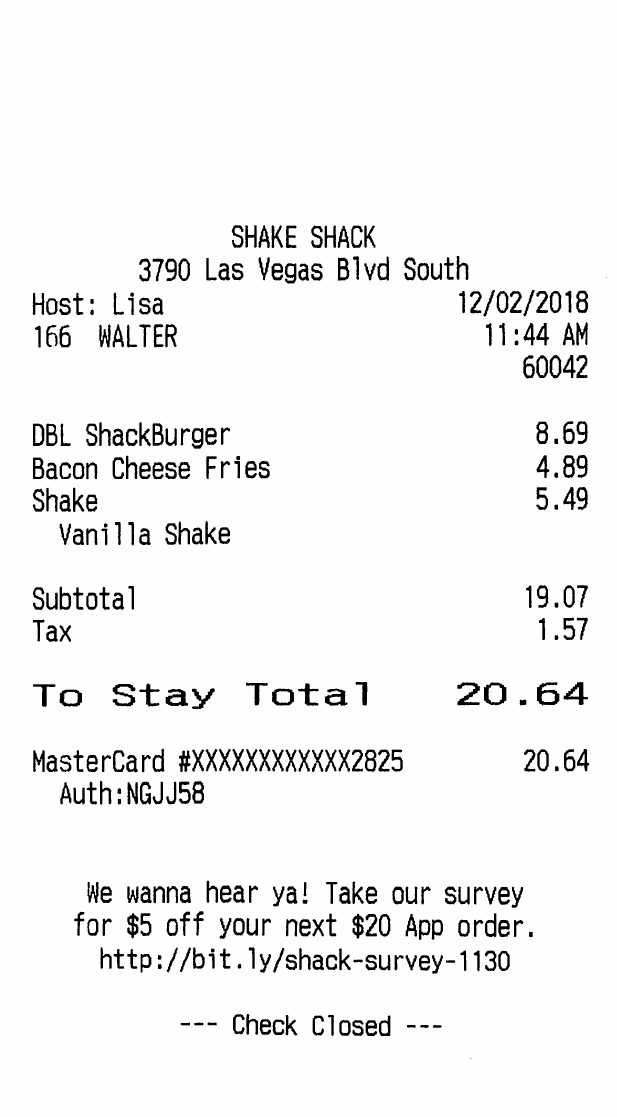

In [ ]:
image = Image.open('ticket.png')
image


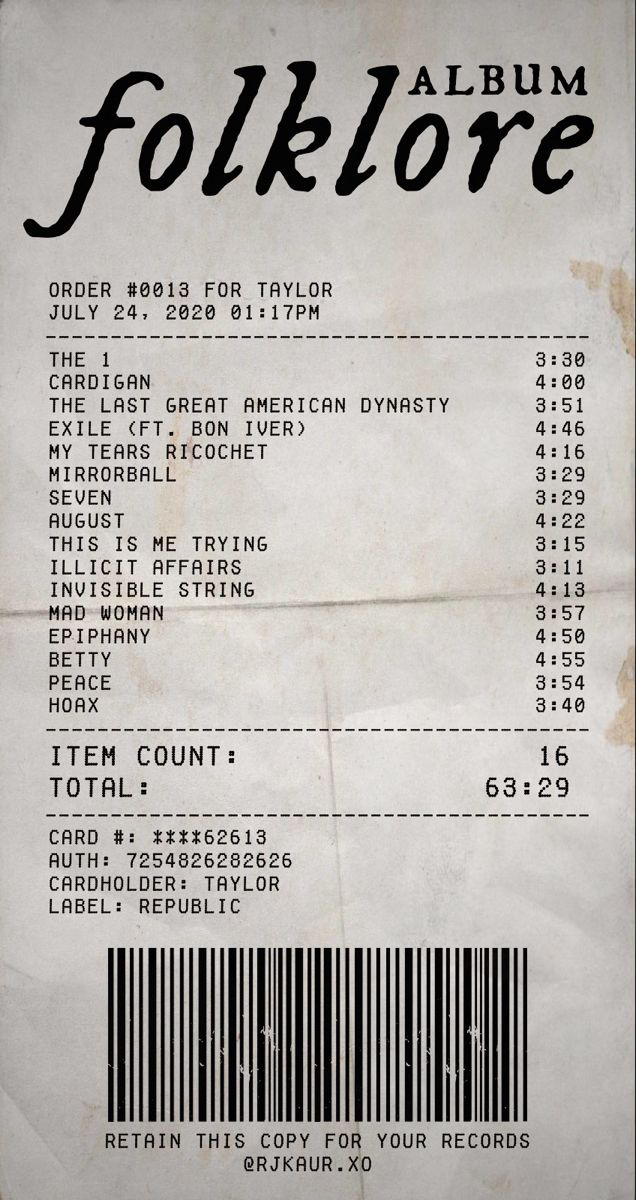

In [ ]:
!curl -s -o ticket2.jpg https://i.pinimg.com/originals/0f/50/54/0f50543167ea6284153c6282918715c4.jpg
image = Image.open('ticket2.jpg')
image


**Tutorial**

Función simple que toma una imagen y devuelve el texto detectado en la imagen.
https://stackabuse.com/pytesseract-simple-python-optical-character-recognition/

In [ ]:
import cv2
import pytesseract
from google.colab.patches import cv2_imshow


def ocr_core(filename):
    """
    This function will handle the core OCR processing of images.
    """
    text = pytesseract.image_to_string(Image.open(filename))  
    return text

text = ocr_core('ticket.png')
print(text)

SHAKE SHACK
3790 Las Vegas Blvd South

Host: Lisa 12/02/2018
166 WALTER 11:44 AM

60042
DBL ShackBurger 8.69
Bacon Cheese Fries 4.89
Shake 5.49

Vanilla Shake

Subtotal 19.07
Tax 1.57

To Stay Total 20.64
MasterCard #XXXXXXXXXXXX2825 20.64
Auth: NGJJ58

We wanna hear ya! Take our survey
for $5 off your next $20 App order.
http://bit.1ly/shack-survey-1130

--- Check Closed ---



**Tutorial**

Bounding box information for each character detected by tesseract during OCR
Ref: https://nanonets.com/blog/ocr-with-tesseract/

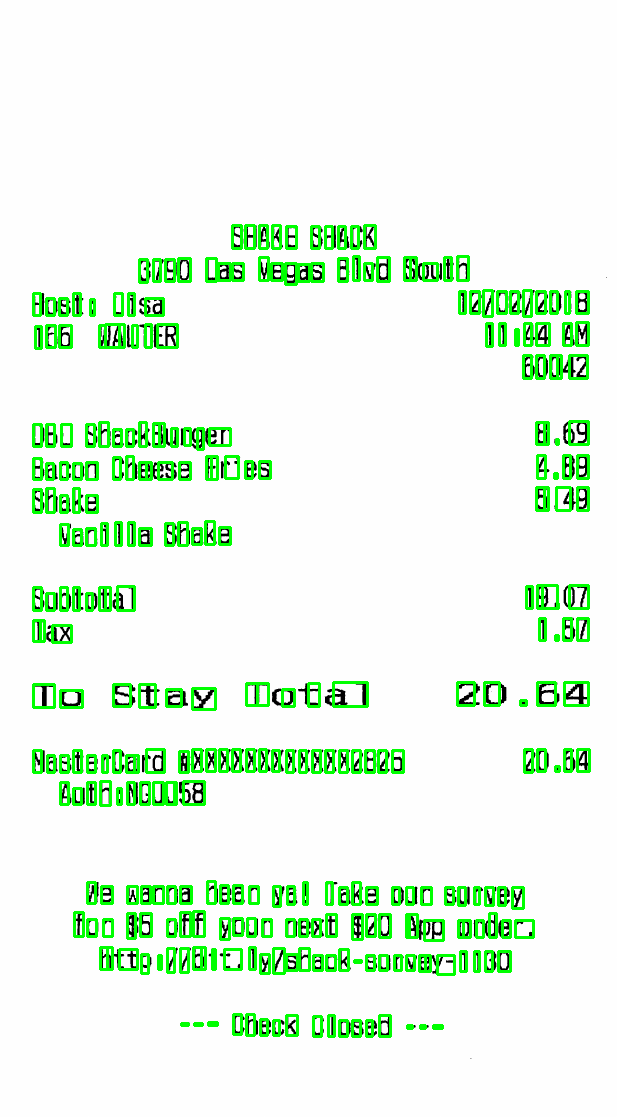

In [ ]:
import cv2
import pytesseract
from google.colab.patches import cv2_imshow

img = cv2.imread('ticket.png')


#bounding box information for each character detected by tesseract during OCR
h, w, c = img.shape
boxes = pytesseract.image_to_boxes(img) 
for b in boxes.splitlines():
    b = b.split(' ')
    img = cv2.rectangle(img, (int(b[1]), h - int(b[2])), (int(b[3]), h - int(b[4])), (0, 255, 0), 2)

cv2_imshow(img)


**Tutorial**

Bounding box around words https://nanonets.com/blog/ocr-with-tesseract/

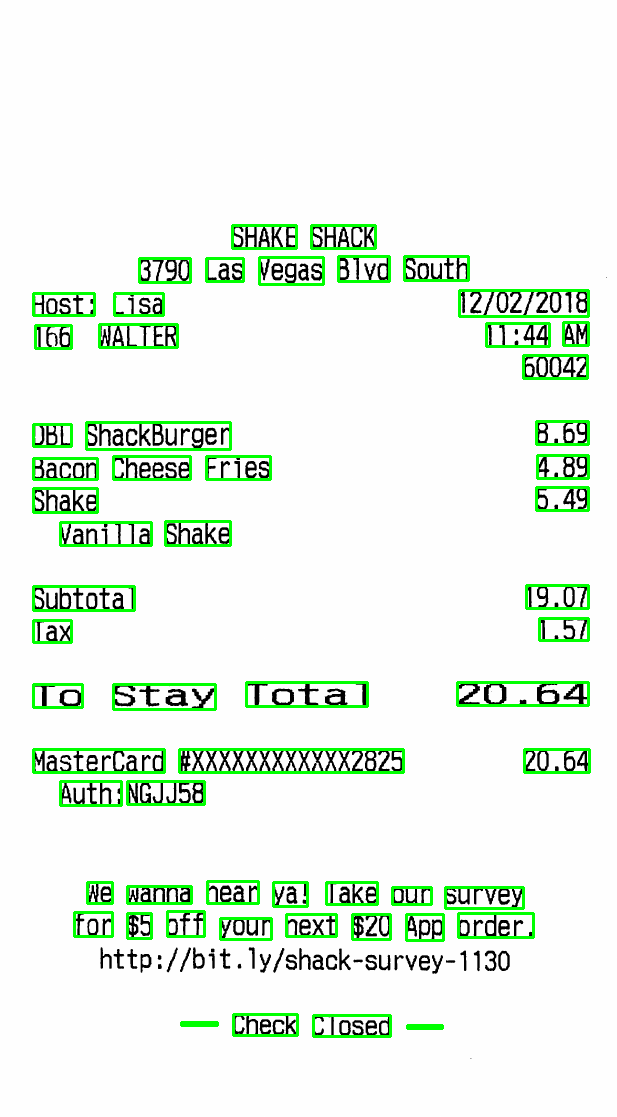

In [ ]:
import cv2
import pytesseract
from pytesseract import Output
from google.colab.patches import cv2_imshow



img = cv2.imread('ticket.png')

d = pytesseract.image_to_data(img, output_type=Output.DICT)

#print(d.keys())
#dict_keys(['level', 'page_num', 'block_num', 'par_num', 'line_num', 'word_num', 'left', 'top', 'width', 'height', 'conf', 'text'])

n_boxes = len(d['text'])
for i in range(n_boxes):
    if int(d['conf'][i]) > 60:
        (x, y, w, h) = (d['left'][i], d['top'][i], d['width'][i], d['height'][i])
        img = cv2.rectangle(img, (x, y), (x + w, y + h), (0, 255, 0), 2)

cv2_imshow(img)

**Tutorial Text template matching**

Take the example of trying to find where a date is in an image. https://nanonets.com/blog/ocr-with-tesseract/ 

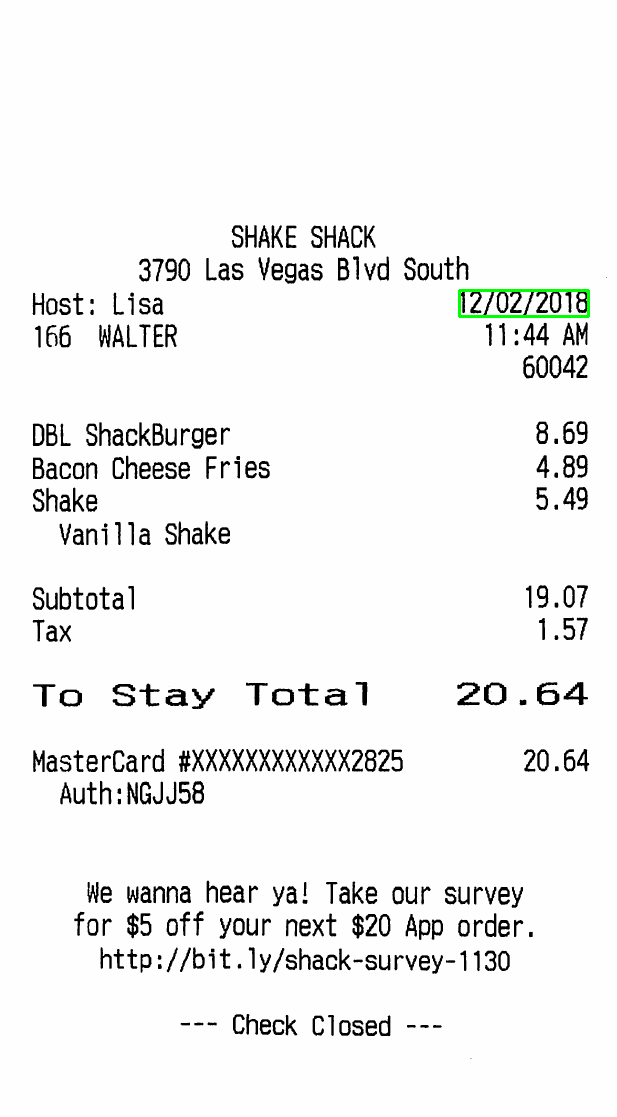

In [ ]:
import re
import cv2
import pytesseract
from pytesseract import Output
from google.colab.patches import cv2_imshow


img = cv2.imread('ticket.png')

d = pytesseract.image_to_data(img, output_type=Output.DICT)
keys = list(d.keys())

date_pattern = '^(0[1-9]|[12][0-9]|3[01])/(0[1-9]|1[012])/(19|20)\d\d$'

n_boxes = len(d['text'])
for i in range(n_boxes):
    if int(d['conf'][i]) > 60:
    	if re.match(date_pattern, d['text'][i]):
	        (x, y, w, h) = (d['left'][i], d['top'][i], d['width'][i], d['height'][i])
	        img = cv2.rectangle(img, (x, y), (x + w, y + h), (0, 255, 0), 2)
         
cv2_imshow(img)

**Buscando el establecimiento de la compra**

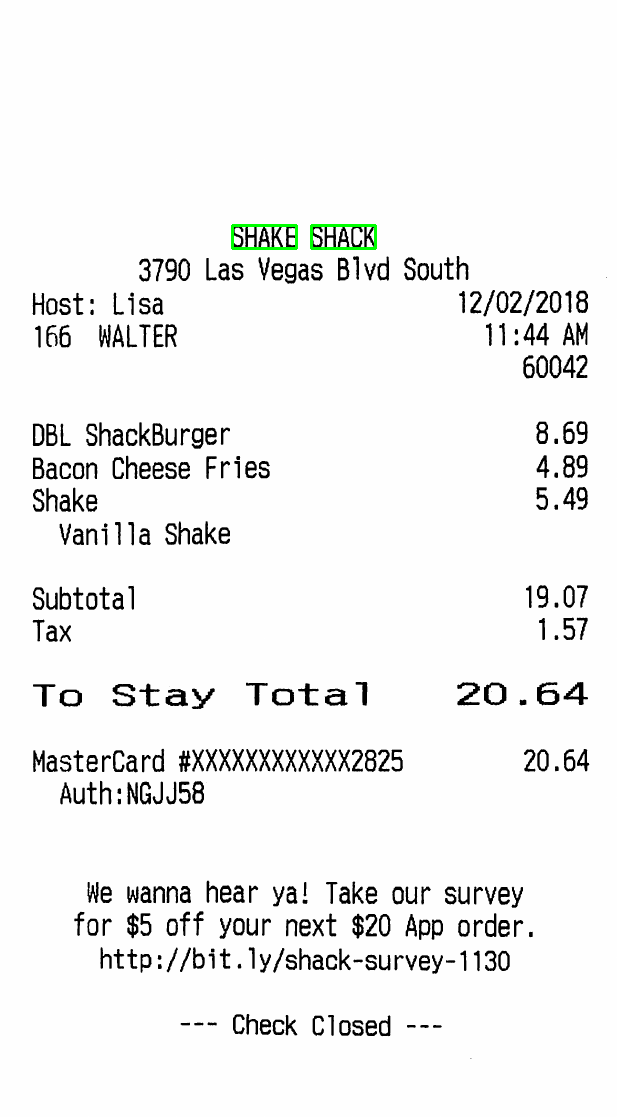

In [ ]:
import re
import cv2
import pytesseract
from pytesseract import Output
from google.colab.patches import cv2_imshow

#image
img = cv2.imread('ticket.png')

# image to data
d = pytesseract.image_to_data(img, output_type=Output.DICT)
keys = list(d.keys())

brand = ''
n_boxes = len(d['text'])
for i in range(n_boxes):
    if int(d['conf'][i]) > 60:
      if d['line_num'][i] == 1 and  d['block_num'][i] == 1:
        (x, y, w, h) = (d['left'][i], d['top'][i], d['width'][i], d['height'][i])
        img = cv2.rectangle(img, (x, y), (x + w, y + h), (0, 255, 0), 2)
         
cv2_imshow(img)


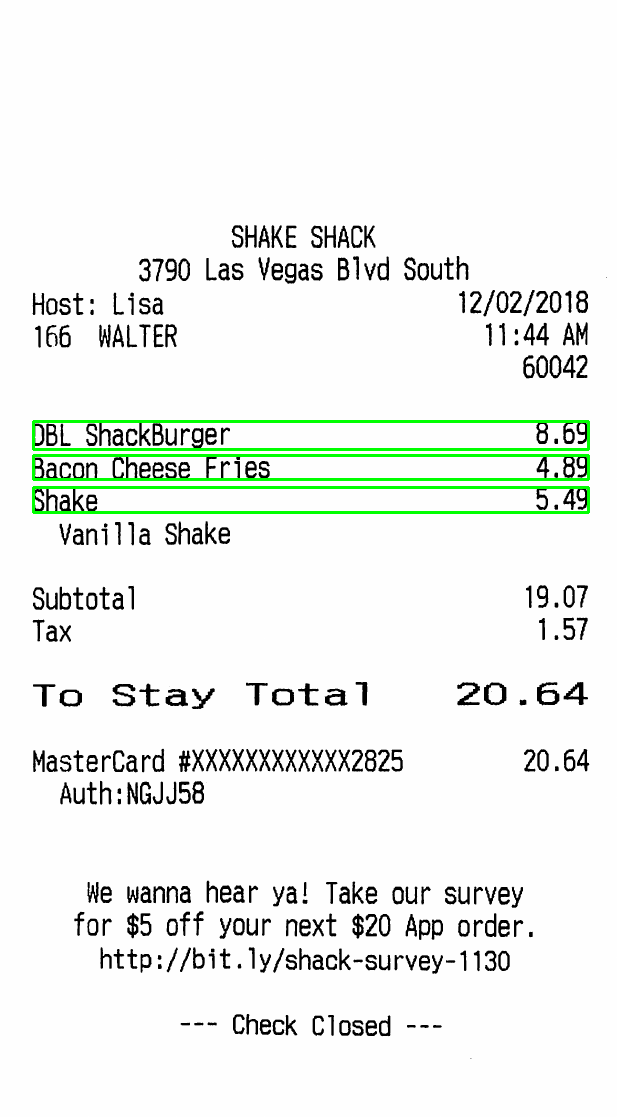

In [ ]:
import re
import cv2
import pytesseract
from pytesseract import Output
from google.colab.patches import cv2_imshow
import json

def lineaElementos(d, i):
    j=i-1
    count = 0
    while d['line_num'][j] == d['line_num'][i] :
      count +=1
      j=j-1
    return count

#Load image
img = cv2.imread('ticket.png')

# OCR image to data
d = pytesseract.image_to_data(img, output_type=Output.DICT)

items = {}
tienda =''
fecha_compra =''

# regex
price_pattern = '\d+\.\d+$'
date_pattern = '^(0[1-9]|[12][0-9]|3[01])/(0[1-9]|1[012])/(19|20)\d\d$'
total_pattern = '(.*otal.*|.*Tax.*)$'

n_boxes = len(d['text'])
for i in range(n_boxes):
    if int(d['conf'][i]) > 60:
        # productos y precios
        if re.match(price_pattern, d['text'][i]) and d['block_num'][i]==2  and not re.match(total_pattern, d['text'][i-1]):
            k = lineaElementos(d,i)
            for j in range(0,k):
              (x, y, w, h) = (d['left'][i-k], d['top'][i-k], d['width'][i-k], d['height'][i-k])
              img = cv2.rectangle(img, (x, y), (x + w, y + h), (0, 255, 0), 2)
         
cv2_imshow(img)

### Extraccion de caracteristicas del ejemplo 1

In [ ]:
import re
import cv2
import pytesseract
from pytesseract import Output
from google.colab.patches import cv2_imshow
import json

	

def findItemName(d, i):
    item_name=""
    item_price =  d['text'][i] 
    j=i-1
    while d['line_num'][j] == d['line_num'][i] :
      item_name=  d['text'][j] + " " +item_name
      j=j-1
    return item_name 

#Load image
img = cv2.imread('ticket.png')

# OCR image to data
d = pytesseract.image_to_data(img, output_type=Output.DICT)

# regex
price_pattern = '\d+\.\d+$'
date_pattern = '^(0[1-9]|[12][0-9]|3[01])/(0[1-9]|1[012])/(19|20)\d\d$'
total_pattern = '(.*otal.*|.*Tax.*)$'

items = {}
tienda =''
fecha_compra =''


n_boxes = len(d['text'])
for i in range(n_boxes):
    if int(d['conf'][i]) > 60:

        # establecimiento
        if d['line_num'][i] == 1 and  d['block_num'][i] == 1:
            tienda = tienda + " "+ d['text'][i]

        # fecha de compra
        if re.match(date_pattern, d['text'][i]):
            fecha_compra = d['text'][i]

        # productos y precios
        if re.match(price_pattern, d['text'][i]) and d['block_num'][i]==2  and not re.match(total_pattern, d['text'][i-1]):
            item_name = findItemName(d,i)
            item_price = d['text'][i]
            items[item_name] = item_price

#almacenamiento en el dicionario
extraccion = {}
extraccion['establecimiento']=tienda
extraccion['fecha_compra']=fecha_compra
extraccion['productos']=items
print(extraccion)  

#guardar diccionario en fichero
with open('data.json', 'w') as fp:
    json.dump(extraccion, fp)      

{'establecimiento': ' SHAKE SHACK', 'fecha_compra': '12/02/2018', 'productos': {' DBL ShackBurger ': '8.69', ' Bacon Cheese Fries ': '4.89', ' Shake ': '5.49'}}
